In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cleaned_Lagos_geocode.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11911 entries, 0 to 11910
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   11911 non-null  object 
 1   LGA                     11911 non-null  object 
 2   Ward                    11911 non-null  object 
 3   PU-Code                 11911 non-null  object 
 4   PU-Name                 11911 non-null  object 
 5   Latitude                11911 non-null  float64
 6   Longitude               11911 non-null  float64
 7   Accredited_Voters       11911 non-null  int64  
 8   Registered_Voters       11911 non-null  int64  
 9   Results_Found           11911 non-null  bool   
 10  Transcription_Count     11911 non-null  int64  
 11  Result_Sheet_Stamped    11911 non-null  bool   
 12  Result_Sheet_Corrected  11911 non-null  bool   
 13  Result_Sheet_Invalid    11911 non-null  bool   
 14  Result_Sheet_Unclear    11911 non-null

In [4]:
def balltree_cluster(df, lat_col = 'Latitude', long_col = 'Longitude', dist_threshold = 1):
    from sklearn.neighbors import BallTree
    #convert the latitude and longitude columns to radians as used by balltree
    df['latitude_rad'] = np.radians(df[lat_col])
    df['longitude_rad'] = np.radians(df[long_col])
    
    coords = df[['latitude_rad', 'longitude_rad']].values

    # Create a BallTree for efficient spatial queries
    tree = BallTree(coords, metric='haversine')
    #calculate the search radius in radians
    radius = dist_threshold / 6371.0 #Earth's radius in km
    # query the tree for each point to find neighbors within the specified distance
    indices = tree.query_radius(coords, r=radius)
    
    #creating clusters for all units
    #create a placeholder cluster for all rows and assign as -1
    cluster = [-1] * len(df)
    #initial cluster_id = 0
    cluster_id = 0
    
    for i, neighbors in enumerate(indices):
        #check if the cluster has been assigned
        if cluster[i] == -1: #if the cluster is yet to be assigned
            #loop through the neigbors and assign clusters to all neighbors of the iteration
            for neighbor in neighbors:
                cluster[neighbor] = cluster_id
            #increment to the next cluster
            cluster_id += 1
            
    return cluster
    
cluster =  balltree_cluster(df, lat_col = 'Latitude', long_col = 'Longitude', dist_threshold = 1)
df['cluster']= cluster

In [5]:
df.head()

,State,LGA,Ward,PU-Code,PU-Name,Latitude,Longitude,Accredited_Voters,Registered_Voters,Results_Found,...,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File,latitude_rad,longitude_rad,cluster
0,LAGOS,AGEGE,ISALE/IDIMANGORO,24-01-01-001,"ST. JOSEPH SECONDARY SCHOOL, MANGORO",6.615283,3.323765,120,744,True,...,False,UNKNOWN,0,0,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,0.115458,0.058011,0
1,LAGOS,AGEGE,ISALE/IDIMANGORO,24-01-01-002,"15, SHOMIDE STREET",6.611684,3.327618,111,716,True,...,False,UNKNOWN,0,0,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,0.115396,0.058078,6
2,LAGOS,AGEGE,ISALE/IDIMANGORO,24-01-01-004,"8, SEBIOTIMO STREET",6.610059,3.327579,108,843,True,...,False,UNKNOWN,31,57,11,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,0.115367,0.058077,6
3,LAGOS,AGEGE,ISALE/IDIMANGORO,24-01-01-005,"6, SEBIOTIMO STREET",6.609893,3.327540,114,731,True,...,False,UNKNOWN,28,66,5,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,0.115364,0.058077,6
4,LAGOS,AGEGE,ISALE/IDIMANGORO,24-01-01-006,WITHIN OLABI SQUARE,6.614014,3.325041,80,539,True,...,False,UNKNOWN,24,28,16,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,0.115436,0.058033,0


In [6]:
# Calculate the mean votes for each party within each cluster
# Group by 'Cluster' and calculate the mean for 'APC', 'LP', 'PDP', and 'NNPP'
cluster_means = df.groupby('cluster')[['APC', 'LP', 'PDP', 'NNPP']].mean().reset_index()

In [7]:
# Rename columns for clarity
cluster_means.columns = ['cluster', 'APC_mean', 'LP_mean', 'PDP_mean', 'NNPP_mean']

In [8]:
# Merge the cluster means back into the original dataframe
df = df.merge(cluster_means, on='cluster', how='left')

In [9]:
# Calculate the deviation from the cluster mean for each party
df['APC_deviation'] = df['APC'] - df['APC_mean']
df['LP_deviation'] = df['LP'] - df['LP_mean']
df['PDP_deviation'] = df['PDP'] - df['PDP_mean']
df['NNPP_deviation'] = df['NNPP'] - df['NNPP_mean']

In [10]:
# Calculate the outlier score for each party (absolute deviation)
df['APC_outlier_score'] = df['APC_deviation'].abs()
df['LP_outlier_score'] = df['LP_deviation'].abs()
df['PDP_outlier_score'] = df['PDP_deviation'].abs()
df['NNPP_outlier_score'] = df['NNPP_deviation'].abs()

In [11]:
# If you want to export to a csv file, use this line of code below.
#df.to_csv('analyzed_lagos_polls.csv', index=False)

In [12]:
# Sort the dataset by the outlier scores for each party
sorted_by_APC = df.sort_values(by='APC_outlier_score', ascending=False).reset_index(drop=True)
sorted_by_LP = df.sort_values(by='LP_outlier_score', ascending=False).reset_index(drop=True)
sorted_by_PDP = df.sort_values(by='PDP_outlier_score', ascending=False).reset_index(drop=True)
sorted_by_NNPP = df.sort_values(by='NNPP_outlier_score', ascending=False).reset_index(drop=True)

In [13]:
# Display the top 3 outliers for each party
sorted_by_APC_top3 = sorted_by_APC[['PU-Code', 'APC', 'APC_mean', 'APC_deviation', 'APC_outlier_score']].head(3)
sorted_by_LP_top3 = sorted_by_LP[['PU-Code', 'LP', 'LP_mean', 'LP_deviation', 'LP_outlier_score']].head(3)
sorted_by_PDP_top3 = sorted_by_PDP[['PU-Code', 'PDP', 'PDP_mean', 'PDP_deviation', 'PDP_outlier_score']].head(3)
sorted_by_NNPP_top3 = sorted_by_NNPP[['PU-Code', 'NNPP', 'NNPP_mean', 'NNPP_deviation', 'NNPP_outlier_score']].head(3)

In [14]:
# Print the top 3 outliers for each party
print("Top 3 APC Outliers:")
print(sorted_by_APC_top3)
print("\nTop 3 LP Outliers:")
print(sorted_by_LP_top3)
print("\nTop 3 PDP Outliers:")
print(sorted_by_PDP_top3)
print("\nTop 3 NNPP Outliers:")
print(sorted_by_NNPP_top3)

Top 3 APC Outliers:
        PU-Code  APC   APC_mean  APC_deviation  APC_outlier_score
0  24-10-06-008  338  39.083333     298.916667         298.916667
1  24-12-17-003  342  77.739130     264.260870         264.260870
2  24-06-04-008  317  72.657143     244.342857         244.342857

Top 3 LP Outliers:
        PU-Code   LP    LP_mean  LP_deviation  LP_outlier_score
0  24-09-03-003  560  49.583333    510.416667        510.416667
1  24-03-02-052  540  48.074627    491.925373        491.925373
2  24-06-01-024  518  27.023810    490.976190        490.976190

Top 3 PDP Outliers:
        PU-Code  PDP   PDP_mean  PDP_deviation  PDP_outlier_score
0  24-06-01-024  554  27.595238     526.404762         526.404762
1  24-10-04-010  312  11.863636     300.136364         300.136364
2  24-08-05-021  124  21.142857     102.857143         102.857143

Top 3 NNPP Outliers:
        PU-Code  NNPP  NNPP_mean  NNPP_deviation  NNPP_outlier_score
0  24-10-04-010   255   5.954545      249.045455          249.04

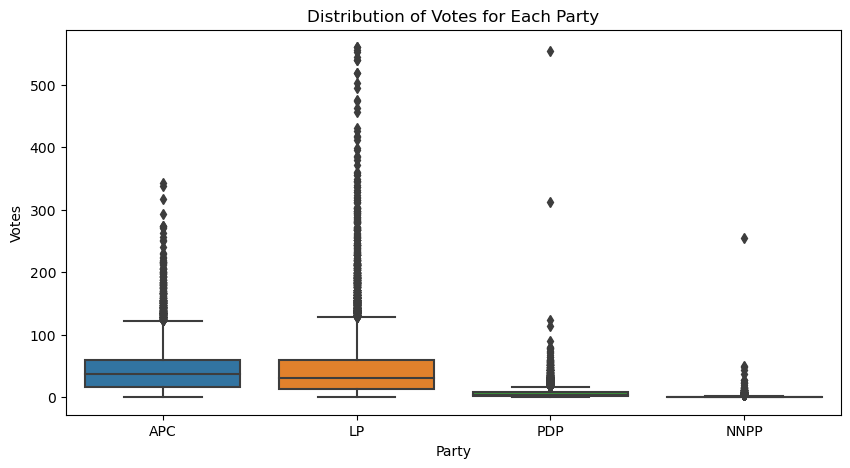

In [15]:
# Visualization: Distribution of votes for each party
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['APC', 'LP', 'PDP', 'NNPP']])
plt.title('Distribution of Votes for Each Party')
plt.xlabel('Party')
plt.ylabel('Votes')
plt.show()

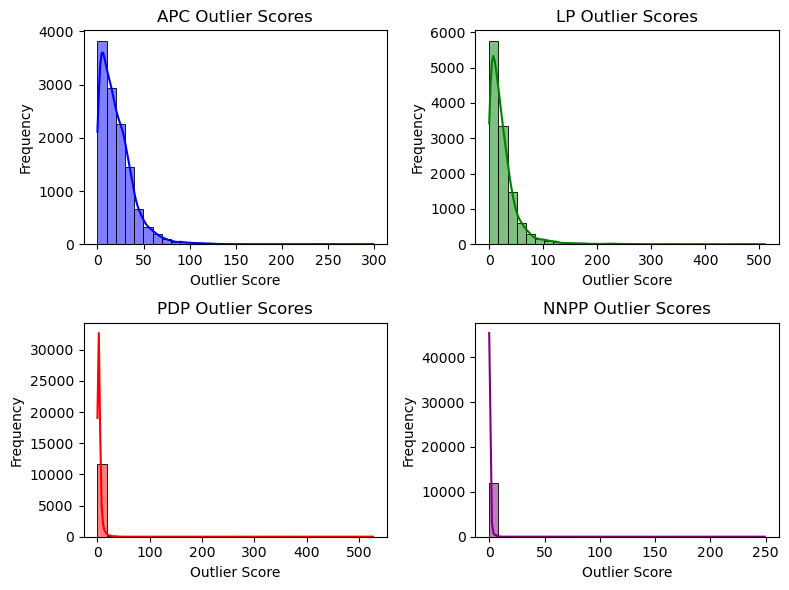

In [16]:
# Visualization: Outlier Scores for each party
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.histplot(df['APC_outlier_score'], bins=30, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('APC Outlier Scores')
axes[0, 0].set_xlabel('Outlier Score')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df['LP_outlier_score'], bins=30, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('LP Outlier Scores')
axes[0, 1].set_xlabel('Outlier Score')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(df['PDP_outlier_score'], bins=30, kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('PDP Outlier Scores')
axes[1, 0].set_xlabel('Outlier Score')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df['NNPP_outlier_score'], bins=30, kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('NNPP Outlier Scores')
axes[1, 1].set_xlabel('Outlier Score')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

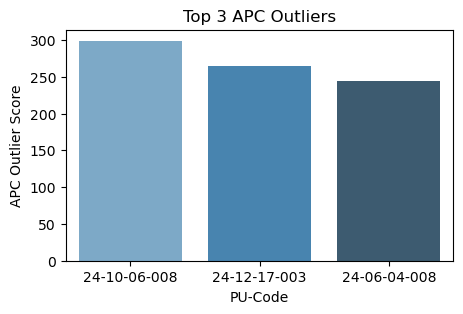

In [17]:
# Visualization: Top 5 outliers for APC
plt.figure(figsize=(5, 3))
sns.barplot(x='PU-Code', y='APC_outlier_score', data=sorted_by_APC_top3, palette='Blues_d')
plt.title('Top 3 APC Outliers')
plt.xlabel('PU-Code')
plt.ylabel('APC Outlier Score')
plt.show()

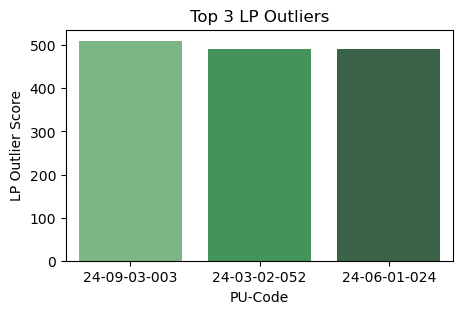

In [18]:
# Visualization: Top 5 outliers for LP
plt.figure(figsize=(5, 3))
sns.barplot(x='PU-Code', y='LP_outlier_score', data=sorted_by_LP_top3, palette='Greens_d')
plt.title('Top 3 LP Outliers')
plt.xlabel('PU-Code')
plt.ylabel('LP Outlier Score')
plt.show()

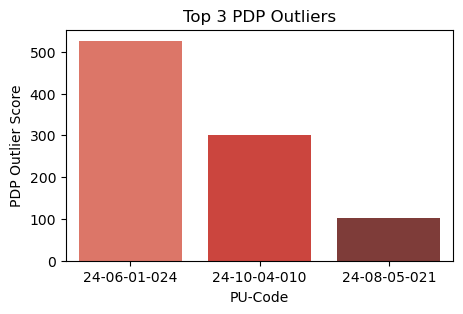

In [19]:
# Visualization: Top 5 outliers for PDP
plt.figure(figsize=(5, 3))
sns.barplot(x='PU-Code', y='PDP_outlier_score', data=sorted_by_PDP_top3, palette='Reds_d')
plt.title('Top 3 PDP Outliers')
plt.xlabel('PU-Code')
plt.ylabel('PDP Outlier Score')
plt.show()

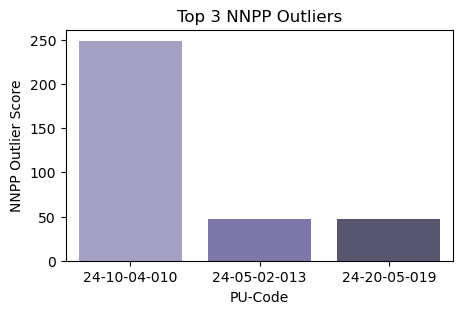

In [20]:
# Visualization: Top 5 outliers for NNPP
plt.figure(figsize=(5, 3))
sns.barplot(x='PU-Code', y='NNPP_outlier_score', data=sorted_by_NNPP_top3, palette='Purples_d')
plt.title('Top 3 NNPP Outliers')
plt.xlabel('PU-Code')
plt.ylabel('NNPP Outlier Score')
plt.show()

   State    LGA              Ward       PU-Code  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-001   
1  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002   
2  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-004   
3  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-005   
4  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-006   

                                PU-Name  Latitude  Longitude  \
0  ST. JOSEPH SECONDARY SCHOOL, MANGORO  6.615283   3.323765   
1                    15, SHOMIDE STREET  6.611684   3.327618   
2                   8, SEBIOTIMO STREET  6.610059   3.327579   
3                   6, SEBIOTIMO STREET  6.609893   3.327540   
4                   WITHIN OLABI SQUARE  6.614014   3.325041   

   Accredited_Voters  Registered_Voters  Results_Found  ...  PDP_deviation  \
0                120                744           True  ...      -8.192308   
1                111                716           True  ...      -3.933333   
2                108                843           True  ...       7.066667

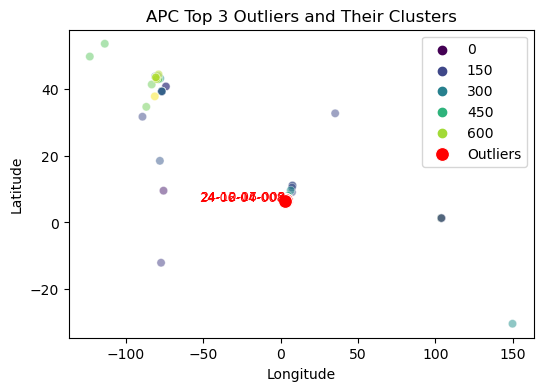

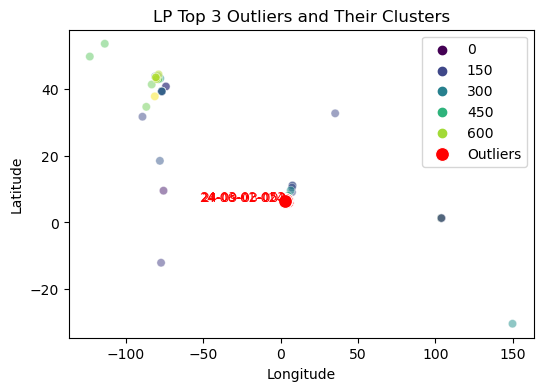

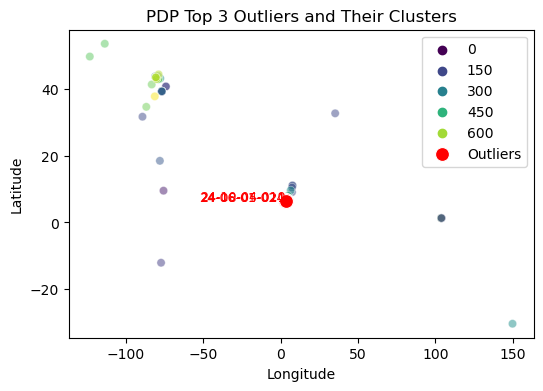

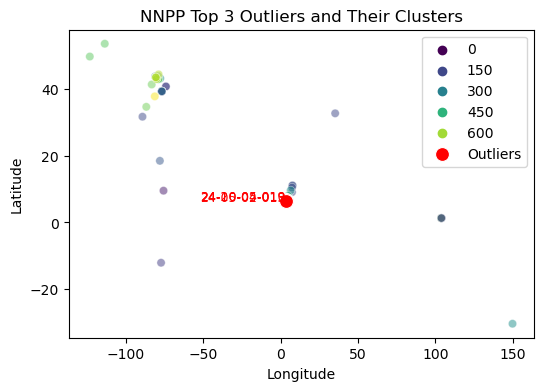

In [21]:

# Haversine formula to calculate distance between two lat/lon points
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate the deviation of votes from neighboring units (clusters)
def calculate_deviation(df, party, cluster_column='cluster', pu_column='PU-Code'):
    deviation_list = []
    for cluster in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster]
        cluster_mean = cluster_data[party].mean()
        for index, row in cluster_data.iterrows():
            deviation = abs(row[party] - cluster_mean)
            deviation_list.append((row[pu_column], deviation))
    return pd.DataFrame(deviation_list, columns=[pu_column, f'{party}_Deviation'])

# Calculate deviations for each party
deviations_apc = calculate_deviation(df, 'APC')
deviations_lp = calculate_deviation(df, 'LP')
deviations_pdp = calculate_deviation(df, 'PDP')
deviations_nnpp = calculate_deviation(df, 'NNPP')

# Merge deviations back into the original dataframe
df = df.merge(deviations_apc, on='PU-Code', how='left')
df = df.merge(deviations_lp, on='PU-Code', how='left')
df = df.merge(deviations_pdp, on='PU-Code', how='left')
df = df.merge(deviations_nnpp, on='PU-Code', how='left')

# Check if the columns have been merged correctly
print(df.head())

# Sort by deviations to identify top 3 outliers for each party
sorted_by_APC = df.sort_values(by='APC_Deviation', ascending=False).head(3)
sorted_by_LP = df.sort_values(by='LP_Deviation', ascending=False).head(3)
sorted_by_PDP = df.sort_values(by='PDP_Deviation', ascending=False).head(3)
sorted_by_NNPP = df.sort_values(by='NNPP_Deviation', ascending=False).head(3)

# Function to plot outliers and their clusters for a specific party
def plot_outliers(df, outliers_df, party, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='Longitude', y='Latitude', hue='cluster', data=df, palette='viridis', alpha=0.5)
    sns.scatterplot(x='Longitude', y='Latitude', data=outliers_df, s=100, color='red', label='Outliers')
    
    for i, row in outliers_df.iterrows():
        plt.text(row['Longitude'], row['Latitude'], row['PU-Code'], fontsize=9, ha='right', color='red')
    
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Add a 'Party' column to distinguish the outliers
sorted_by_APC['Party'] = 'APC'
sorted_by_LP['Party'] = 'LP'
sorted_by_PDP['Party'] = 'PDP'
sorted_by_NNPP['Party'] = 'NNPP'

# Plot the top 3 outliers and their clusters for each party
plot_outliers(df, sorted_by_APC, 'APC', 'APC Top 3 Outliers and Their Clusters')
plot_outliers(df, sorted_by_LP, 'LP', 'LP Top 3 Outliers and Their Clusters')
plot_outliers(df, sorted_by_PDP, 'PDP', 'PDP Top 3 Outliers and Their Clusters')
plot_outliers(df, sorted_by_NNPP, 'NNPP', 'NNPP Top 3 Outliers and Their Clusters')